<a href="https://colab.research.google.com/github/PascalPolygon/AffineCNN/blob/main/translation_vector_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSE 5290: Translation Vector Estimation (Graduate Student Project)**
Pascal Dao (pdao2015@my.fit.edu) and Ruksana Kabealo (rkabealo@my.fit.edu) \
Florida Institute of Technology — September 11th, 2021 through XXXXX

This code generates the "Shape Movements Dataset" - a dataset of various 2D shapes experiencing the following affine transformations: translation, rotation, and scaling. 

This becomes a 6 Degrees of Freedom system. As such, we save our transformation as the 6 usable values from the affine matrix: a, b, c, d, e, and f. 

We will be using matplotlib to generate the shapes. 

**TODO: **

Ruksana: 
* given a bounding box, generate a randomly sized polygon at a random center POINT within (make sure to check appropriately to make sure it's not initially generated offscreen) 
* somehow pass the max ability to be translated to the translation function so it's distribution changes and it never moves the polygon off screen 
* figure out how to incorporate curved polygons into generated translations 

Pascal: 
* fix the data loader problems
* start working on setting up the online transformations code 

For the meeting
* Decide on an image width/height and stick to it

## Code

### Imports and Configuration

Import necessary libraries. 

In [4]:
# Imports
#from ipycanvas import Canvas, hold_canvas, MultiCanvas
import math 
import numpy as np
from numpy.random import default_rng
import csv
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Arc, Ellipse, RegularPolygon, PathPatch
import matplotlib.path as mpath 
import bisect 
import operator
import collections
from google.colab import drive
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from glob import glob
import time

In [5]:
from google.colab import auth
auth.authenticate_user()

In [6]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0    99k      0 --:--:-- --:--:-- --:--:--   99k
OK
43 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 43 not upgraded.
Need to get 11.3 MB of archives.
After this operation, 24.0 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.37.0_amd64.deb ...
Unpacking gcsfuse (0.37.0) ...
Setting up gcsfuse (0.37.0) ...


In [7]:
!mkdir SMD_V3
!gcsfuse --implicit-dirs translation_vector_estimation_bucket SMD_V3

2021/12/02 16:44:03.869973 Start gcsfuse/0.37.0 (Go version go1.17.2) for app "" using mount point: /content/SMD_V3
2021/12/02 16:44:03.878760 Opening GCS connection...
2021/12/02 16:44:04.305246 Mounting file system "translation_vector_estimation_bucket"...
2021/12/02 16:44:04.337923 File system has been successfully mounted.


Set up where we'll be saving the data.

In [8]:
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
# PATH_TO_ORIGINAL_IMGS = '/content/drive/MyDrive/translation_vector_estimation_project/data/input/original'
# PATH_TO_TRANSLATED_IMGS = '/content/drive/MyDrive/translation_vector_estimation_project/data/input/translated'
# PATH_TO_LABELS = '/content/drive/MyDrive/translation_vector_estimation_project/data/labels'

PATH_TO_ORIGINAL_IMGS = '/content/SMD_V3/SMD_V3_COMB/input/original'
PATH_TO_TRANSLATED_IMGS = '/content/SMD_V3/SMD_V3_COMB/input/transformed'
PATH_TO_LABELS = '/content/SMD_V3/SMD_V3_COMB/labels'

PATH_TO_MODELS = '/content/drive/MyDrive/translation_vector_estimation_project/models'

Create default dimensions for the images. 

In [10]:
# Image dimensions 
IMG_WIDTH = 256
X_AXIS_LIM = IMG_WIDTH/2
IMG_HEIGHT = 256
Y_AXIS_LIM = IMG_HEIGHT/2
MIN_RADIUS = 12
MAX_RADIUS = 128

## Shape Generation


TODO: explain further the decision making process behind what we're doing. Why these categories. 

The different types of shapes considered for this project are: 
* Regular polygons 
* Ellipses
* Randomly generated convex polygons (using Valtr's algorithm)
* Randomly generated with random curve incorporation (matplotlib path + bezel curves 3 and 4) 

We developed the code for generating these different types of shapes.

### Regular Polygon Generation

#### Generation Function

In [ ]:
"""
This function takes in: 
* the center coordinates (x and y)
* a radius length
* the number of points for the polygon 

and returns: 
* a regular n-sided polygon with the specified radius
"""
def generate_regular_polygon(center_x, center_y, number_of_points):
    # Check for invalid input
    if number_of_points <= 2: 
        print("Invalid number of points!")
        return -1
    else: 
        p = RegularPolygon((center_x, center_y), number_of_points, radius, facecolor='k')
        return p

#### Example

Below is an example of generating a regular 6-sided polygon. 

In [ ]:
"""
Get the vertices for a 6-sided polygon centered around (0,0) that has the radius specified 
"""
example_regular_6_side_poly = generate_regular_polygon(0, 0, 6)

# Create figure 
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
padding = 15

# Plot the 6-sided polygon as a list of points 
axs[0].set_xlim([-X_AXIS_LIM, X_AXIS_LIM])
axs[0].set_ylim([-Y_AXIS_LIM, Y_AXIS_LIM])

vertices = example_regular_6_side_poly.get_path().vertices
trans = example_regular_6_side_poly.get_patch_transform()
points = trans.transform(vertices)

pts = list(zip(*points))
axs[0].scatter(pts[0],pts[1], c='k')

# Plot the 6-sided polygon as a filled-in shape 
axs[1].set_xlim([-50, 50])
axs[1].set_ylim([-50, 50])
axs[1].add_patch(example_regular_6_side_poly)

plt.show()

TypeError: ignored

### Ellipse Polygon Generation

#### Generation Function

In [ ]:
"""
This function takes in: 
* the center coordinates (x and y)
* a maximum width 
* a maximum height 

and returns: 
* an ellipse patch centered at (x,y) with a random width between 
[max_width/10, max_width] and a random height between [max_height/10, max_height] 
and with a random tilt between [0,360] degrees
"""
def generate_ellipse(center_x, center_y, max_width, max_height):
    # Minimum size is a 10th of the space it could be generated in
    random_width = np.random.randint(max_width/10, max_width)
    random_height = np.random.randint(max_height/10, max_height)
    
    # We can't have the randomly generated width/height ending up too close together 
    # If they do - our ellipse will look too much like a circle for our algorithm to distinguish 
    # Let's ensure that the randomly generated ellipse never exceeds 1:2/2:1 width:height/height:width ratio 
    while abs(random_width/random_height) > 1/2 and abs(random_width/random_height) < 2/1:
        random_width = np.random.randint(max_width/10, max_width)
        random_height = np.random.randint(max_height/10, max_height)
    
    # Generate a random tilt 
    random_tilt = np.random.randint(0, 360)
    
    # Compile the final patch
    e = Ellipse((center_x, center_y), random_width, random_height, angle=random_tilt, facecolor='k',fill=True)
    
    return e

#### Example

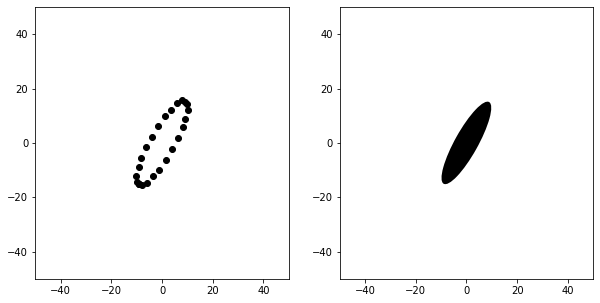

In [ ]:
"""
Get the vertices for an ellipse centered around (0,0) that is contained within -25 and +25 on the x-axis 
and -25 and +25 on the y-axis
"""
example_ellipse = generate_ellipse(0, 0, 50, 50)

# Create figure 
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# Plot the 6-sided polygon as a list of points 
axs[0].set_xlim([-50, 50])
axs[0].set_ylim([-50, 50])

verts = example_ellipse.get_path().vertices
trans = example_ellipse.get_patch_transform()
points = trans.transform(verts)

pts = list(zip(*points))
axs[0].scatter(pts[0],pts[1], c='k')

# Plot the ellipse as a filled-in shape 
axs[1].set_xlim([-50, 50])
axs[1].set_ylim([-50, 50])
axs[1].add_patch(example_ellipse)

plt.show()

### Randomly Generated Convex Polygon Generation (Valtr's Algorithm)

TODO: Credit Valt'rs algorithm to the right source

#### Generation Function

In [ ]:
"""
This function takes in: 
* the center coordinates (x and y) of some area to generate the polygon within 
* the width of the area to generate the polygon within 
* the height of the area to generate the polygon within 
* the number of points for the polygon 

and returns: 
* the vertices for a randomly generated convex polygon - in counterclockwise order of the convex hull 
"""
def generate_random_convex_polygon(center_x, center_y, max_width, max_height, number_of_points):
    # Figure out the bounding box for where we're generating this arbitrary polygon 
    min_x = center_x - (max_width / 2.0) 
    max_x = center_x + (max_width / 2.0) 
    min_y = center_y - (max_height / 2.0)
    max_y = center_y + (max_height / 2.0)
    
#     print("""Creating bounding box from {min_x} to {max_x} in the x-direction and {min_y} to {max_y} in the y-direction""".format(min_x=min_x, max_x=max_x, min_y=min_y, max_y=max_y))
    
    # Generate two sorted lists of random x and y coordinates 
    random_x_coordinates = np.sort(np.random.randint(min_x, max_x, size=number_of_points))
    random_y_coordinates = np.sort(np.random.randint(min_y, max_y, size=number_of_points))
    
#     print("Randomly generated x coordinates: {lx}".format(lx=str(random_x_coordinates)))
#     print("Randomly generated y coordinates: {ly}".format(ly=str(random_y_coordinates)))
    
    # Get the biggest and smallest values (the "extreme" points)
    # The list is sorted - so we can grab the first and last elements
    max_x = random_x_coordinates[-1]
    max_y = random_y_coordinates[-1]
    min_x = random_x_coordinates[0]
    min_y = random_y_coordinates[0]
    
#     print("Extreme x coordinates: {min_x} (smallest) and {max_x} (biggest)".format(min_x=min_x, max_x=max_x))
#     print("Extreme x coordinates: {min_y} (smallest) and {max_y} (biggest)".format(min_y=min_y, max_y=max_y))
    
    # Randomly divide the non-extreme points into two chains
    # Extreme are found at 0 and at len-1 
    x_vec = np.empty(number_of_points)
    y_vec = np.empty(number_of_points)
    
    # x vector 
    last_seen_top = min_x
    last_seen_bottom = min_x
    
    # For each non-extreme point...
    for i in range(1, number_of_points - 1):
        x = random_x_coordinates[i]
        
        if(bool(random.randrange(2))): 
            x_vec[i - 1] = x - last_seen_top
            last_seen_top = x
        else: 
            x_vec[i - 1] = last_seen_bottom - x 
            last_seen_bottom = x
           
    x_vec[number_of_points - 2] = max_x - last_seen_top 
    x_vec[number_of_points - 1] = last_seen_bottom - max_x
    
    # y vector 
    last_seen_right = min_y
    last_seen_left = min_y
    
    for i in range(1, number_of_points - 1):
        temp_y = random_y_coordinates[i]
        
        if(bool(random.randrange(2))): 
            y_vec[i - 1] = temp_y - last_seen_left
            last_seen_left = temp_y
        else:
            y_vec[i - 1] = last_seen_right - temp_y
            last_seen_right = temp_y
    
    y_vec[number_of_points - 2] = max_y - last_seen_left
    y_vec[number_of_points - 1] = last_seen_right - max_y
    
    # Randomly pair the x and ys 
    random.shuffle(y_vec)
    
    # Combine the paired up components into vectors
    def find_vector_angle(v): 
        return math.atan2(v[1], v[0]) 
    
    # Sort the vectors by angle
    vectors = np.array(sorted(zip(x_vec, y_vec), key = find_vector_angle))
    
#     print("VECTORS:")
#     print(vectors)

    # Lay them end-to-end
    new_x = 0 
    new_y = 0 
    min_polygon_x = 0 
    min_polygon_y = 0
    
    points = []

    for vector_x, vector_y in vectors: 
        points.append((new_x, new_y))
        
        new_x += vector_x
        new_y += vector_y
        
        min_polygon_x = min(min_polygon_x, new_x)
        min_polygon_y = min(min_polygon_y, new_y)
        
        
    # Move the polygon to the original min and max coordinates
    shift_x = min_x - min_polygon_x;
    shift_y = min_y - min_polygon_y;
        
    points = [(point_x + shift_x, point_y + shift_y) for point_x, point_y in points]
    
#     print("POINTS")
#     print(points)
    return np.array(points)

#### Example

To show that our implementation of Valtr's Algorithm works as we expect it to - we can generate the points for an 6-sided polygon and plot it. 

TypeError: ignored

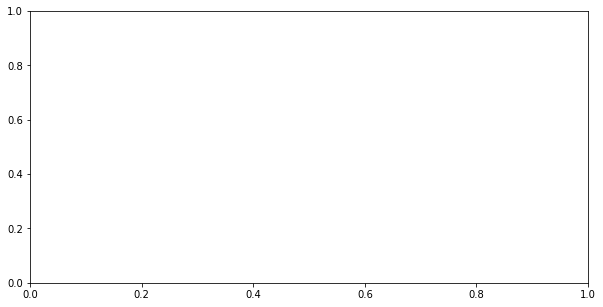

In [ ]:
"""
Get the vertices for a 6-sided polygon centered around (0,0) that is contained within -25 and +25 on the x-axis 
and -25 and +25 on the y-axis
"""
#example_random_convex_6_size_poly = generate_random_convex_polygon(0, 0, 50, 50, 6)

# Create figure 
fig, axs = plt.subplots(figsize=(10,5))

# Plot the 6-sided polygon as a list of points 
axs[0].set_xlim([-50, 50])
axs[0].set_ylim([-50, 50])

pts = list(zip(*example_random_convex_6_size_poly))
print("Vertices are: " + str(example_random_convex_6_size_poly))
axs[0].scatter(pts[0],pts[1], c='k')

for i,v in enumerate(example_random_convex_6_size_poly):
    axs[0].annotate("V" + str(i), (v[0], v[1]))

# Plot the 6-sided polygon as a filled-in shape 
axs[1].set_xlim([-50, 50])
axs[1].set_ylim([-50, 50])
poly = Polygon(example_random_convex_6_size_poly, facecolor='k')
axs[1].add_patch(poly)

plt.show()

### Randomly Generated Convex Polygon with Bezier Curves Generation

#### Generation Function

In [ ]:
"""
This function assumes: 
* the vertices are given in either a clockwise or counterclockwise 
ordering of the convex hull 

and takes in: 
* a list of vertices describing a convex polygon

and returns: 
* n new patchs describing n new polygons - one for a quadratic Bezier 
curve taking the place of each edge 
"""
def generate_quad_Beziered_convex_polygons(vertices):
    num_vertices = len(vertices)
    codes_default = [1]
    
    name = 0
    
    # Quadratic
    codes_quad_transform = [3,3] + ([2] * (num_vertices-3))
    for i in range(num_vertices-2): 
        codes = codes_default + codes_quad_transform[-i:] + codes_quad_transform[:-i]

        path = mpath.Path(vertices, codes)

        curve_points = [i for i, j in zip(vertices, codes) if j==3]

        print("Quadratic Bezier curve applied to the following points: ") 
        for i in curve_points: 
            print("* " + str(i))
        fig, axs = plt.subplots(figsize=(10,5))
        patch = PathPatch(path, facecolor='k', fill=True, lw=2)
        axs.add_patch(patch)
        crv_pts = list(zip(*curve_points))
        axs.scatter(pts[0], pts[1], c='r', marker='x')
        axs.scatter(crv_pts[0], crv_pts[1], c='g', marker='x')
        axs.set_xlim([-50, 50])
        axs.set_ylim([-50, 50])
        fig.savefig("quad_" + str(name) + ".png", dpi=400)
        name += 1
        
    for i in [2,1]:
        shifted_vertices = collections.deque(vertices)
        shifted_vertices.rotate(i)
        shifted_vertices = list(shifted_vertices)
        codes = codes_default + codes_quad_transform 
        
        path = mpath.Path(shifted_vertices, codes)

        curve_points = [i for i, j in zip(shifted_vertices, codes) if j==3]

        print("Quadratic Bezier curve applied to the following points: ") 
        for i in curve_points: 
            print("* " + str(i))
        fig, axs = plt.subplots(figsize=(10,5))
        patch = PathPatch(path, facecolor='k', fill=True, lw=2)
        axs.add_patch(patch)
        crv_pts = list(zip(*curve_points))
        axs.scatter(pts[0], pts[1], c='r', marker='x')
        axs.scatter(crv_pts[0], crv_pts[1], c='g', marker='x')
        axs.set_xlim([-50, 50])
        axs.set_ylim([-50, 50])
        fig.savefig("quad_" + str(name) + ".png", dpi=400)
        name += 1

In [ ]:
print("Vertices are: ")
print(example_random_convex_6_size_poly)

generate_quad_Beziered_convex_polygons(example_random_convex_6_size_poly)

Vertices are: 


NameError: ignored

In [ ]:
"""

"""
def generate_cub_Beziered_convex_polygons(vertices):
    num_vertices = len(vertices)
    codes_default = [1]
    
    name = 0
    
    # Quadratic
    codes_quad_transform = [4,4,4] + ([2] * (num_vertices-4))
    for i in range(num_vertices-3): 
        codes = codes_default + codes_quad_transform[-i:] + codes_quad_transform[:-i]

        path = mpath.Path(vertices, codes)

        curve_points = [i for i, j in zip(vertices, codes) if j==4]

        print("Cubic Bezier curve applied to the following points: ") 
        for i in curve_points: 
            print("* " + str(i))
        fig, axs = plt.subplots(figsize=(10,5))
        patch = PathPatch(path, facecolor='k', fill=True, lw=2)
        axs.add_patch(patch)
        crv_pts = list(zip(*curve_points))
        axs.scatter(pts[0], pts[1], c='r', marker='x')
        axs.scatter(crv_pts[0], crv_pts[1], c='g', marker='x')
        axs.set_xlim([-50, 50])
        axs.set_ylim([-50, 50])
        fig.savefig("cubic_" + str(name) + ".png", dpi=400)
        name += 1
        
    for i in [3,2,1]:
        shifted_vertices = collections.deque(vertices)
        shifted_vertices.rotate(i)
        shifted_vertices = list(shifted_vertices)
        codes = codes_default + codes_quad_transform 
        
        path = mpath.Path(shifted_vertices, codes)

        curve_points = [i for i, j in zip(shifted_vertices, codes) if j==4]

        print("Cubic Bezier curve applied to the following points: ") 
        for i in curve_points: 
            print("* " + str(i))
        fig, axs = plt.subplots(figsize=(10,5))
        patch = PathPatch(path, facecolor='k', fill=True, lw=2)
        axs.add_patch(patch)
        crv_pts = list(zip(*curve_points))
        axs.scatter(pts[0], pts[1], c='r', marker='x')
        axs.scatter(crv_pts[0], crv_pts[1], c='g', marker='x')
        axs.set_xlim([-50, 50])
        axs.set_ylim([-50, 50])
        fig.savefig("cubic_" + str(name) + ".png", dpi=400)
        name += 1

In [ ]:
print("Vertices are: ")
print(example_random_convex_6_size_poly)

generate_cub_Beziered_convex_polygons(example_random_convex_6_size_poly)

#### Example

Here we use a 6-sided polygon randomly generated by the algorithm above. 

In [ ]:
"""
Show an example of a quadratic bezier curve between two points on a randomly generated 6-sided polygon
"""
vertices = example_random_convex_6_size_poly

#[[-23, 5], [-23, -10], [8,-17], [22,-13.], [16,-6], [0, -1]]

fig, axs = plt.subplots(ncols=3, figsize=(20,6))
fig.suptitle('6-Sided Randomly Generated Convex Polygon with Quadratic Bezier Curve', fontsize=16)

# Plot the 6-sided polygon as a list of points 
axs[0].set_xlim([-50, 50])
axs[0].set_ylim([-50, 50])

print("Vertices are:" + str(vertices))
pts = list(zip(*vertices))
axs[0].scatter(pts[0],pts[1], c='r', marker='x')
for i,v in enumerate(vertices):
    axs[0].annotate("(" + str(v[0]) + ", " + str(v[1]) + ")", (v[0], v[1]))

# Plot the 6-sided polygon as a filled-in shape 
axs[1].set_xlim([-50, 50])
axs[1].set_ylim([-50, 50])
poly = Polygon(vertices, facecolor='k')
axs[1].add_patch(poly)
axs[1].scatter(pts[0],pts[1], c='r', marker='x')

codes = [
    mpath.Path.MOVETO,
    mpath.Path.LINETO,
    mpath.Path.LINETO,
    mpath.Path.LINETO,
    mpath.Path.CURVE3,
    mpath.Path.CURVE3,
]

print(codes)

path = mpath.Path(vertices, codes)

curve_points = [vertices[1], vertices[2], vertices[5]]

#[i for i, j in zip(vertices, codes) if j==3]

print("Quadratic Bezier curve applied to the following points: ") 
for i in curve_points: 
    print("* " + str(i))
    
patch = PathPatch(path, facecolor='k', fill=True, lw=2)
axs[2].add_patch(patch)
crv_pts = list(zip(*curve_points))
axs[2].scatter(pts[0], pts[1], c='r', marker='x')
axs[2].scatter(crv_pts[0], crv_pts[1], c='g', marker='x')
axs[2].set_xlim([-50, 50])
axs[2].set_ylim([-50, 50])

In [ ]:
"""
Show an example of a cubic bezier curve between three points on a randomly generated 6-sided polygon
"""
#vertices = example_random_convex_6_size_poly

print(vertices)

fig, axs = plt.subplots(ncols=3, figsize=(20,6))
fig.suptitle('6-Sided Randomly Generated Convex Polygon with Cubic Bezier Curve', fontsize=16)

# Plot the 6-sided polygon as a list of points 
axs[0].set_xlim([-50, 50])
axs[0].set_ylim([-50, 50])

pts = list(zip(*vertices))
axs[0].scatter(pts[0],pts[1], c='r', marker='x')
for i,v in enumerate(vertices):
    axs[0].annotate("(" + str(v[0]) + ", " + str(v[1]) + ")", (v[0], v[1]))

# Plot the 6-sided polygon as a filled-in shape 
axs[1].set_xlim([-50, 50])
axs[1].set_ylim([-50, 50])
poly = Polygon(vertices, facecolor='k')
axs[1].add_patch(poly)
axs[1].scatter(pts[0],pts[1], c='r', marker='x')

codes = [
    mpath.Path.MOVETO,
    mpath.Path.LINETO,
    mpath.Path.LINETO,
    mpath.Path.CURVE4,
    mpath.Path.CURVE4,
    mpath.Path.CURVE4,
]

path = mpath.Path(vertices, codes)

curve_points = [vertices[2], vertices[3], vertices[4], vertices[5]] #[i for i, j in zip(vertices, codes) if j==4]

print("Cubic Bezier curve applied to the following points: ") 
for i in curve_points: 
    print("* " + str(i))

patch = PathPatch(path, facecolor='k', fill=True, lw=2)
axs[2].add_patch(patch)
crv_pts = list(zip(*curve_points))
axs[2].scatter(pts[0], pts[1], c='r', marker='x')
axs[2].scatter(crv_pts[0], crv_pts[1], c='g', marker='x')
axs[2].set_xlim([-50, 50])
axs[2].set_ylim([-50, 50])

In [ ]:
datasetSize = 1500
for i in range(datasetSize):
#Original
  filename = str(i)
  filepath = os.path.join(PATH_TO_ORIGINAL_IMGS, filename)

  verts = generate_random_convex_polygon(0, 0, 50, 50, 7)
  savePoly(verts, filepath)

  #Transormation
  filepath = os.path.join(PATH_TO_TRANSLATED_IMGS, filename)

  # Random transformation paratmers
  dx = np.random.uniform(-20,20,1)[0]
  dy = np.random.uniform(-20,20,1)[0]
  theta = np.random.uniform(0,360,1)[0]
  sx = np.random.uniform(0.4,2,1)[0]
  sy = np.random.uniform(0.4,2,1)[0]

  params = np.array([dx, dy, theta, sx, sy])
  A, S = getTransformations(params)
  verts_t = applyTranformation(verts, A, S)
  savePoly(verts_t, filepath)

  #Save label (transformation params)
  filepath = os.path.join(PATH_TO_LABELS, filename)
  np.save(filepath+'.npy', params)

## Generating dataset

## Dataset Loader

In [11]:
def linInterpol(x, x1 = -256.0, y1 = -10.0, x2 = 256.0, y2 = 10.0):
  return y1+((y2-y1)/(x2-x1))*(x-x1)

In [12]:
class AffineDataset(Dataset):
  def __init__(self, img_dir, img_t_dir, annotations_dir, transform=None, target_transform=None, norm_out= False):
        # self.img_labels = pd.read_csv(annotations_file)
        # self.img_labels = np.load(annotations_)
        self.norm_out = norm_out
        self.annotations_dir = annotations_dir
        self.img_dir = img_dir
        self.img_t_dir = img_t_dir
        self.transform = transform
        self.target_transform = target_transform
        self.paths = []
        for path in glob(self.img_dir+'/*png'):
          self.paths.append(path)

  def __len__(self):
      return len(self.paths)

  def __getitem__(self, idx):
      img_path = self.paths[idx]
      filename = os.path.basename(img_path).split('.')[0]
      # img_path = os.path.join(self.img_dir, str(idx)+'.png')
      img_t_path = os.path.join(self.img_t_dir, filename+'.png')
      image = read_image(img_path)
      image_t = read_image(img_t_path)
      #plt.imsave saves 4 channels for some reason, ignore the last one
      image = image[:3,:,:] 
      image_t = image_t[:3,:,:]
      label_segments = filename.split('_')
      if label_segments[-1] == 'cub':
        labelname = filename[:-4]
      elif label_segments[-1] == 'quad':
        labelname = filename[:-5]
      else:
        labelname = filename
      # print(f'File name: {filename}')
      # print(f'Label name : {labelname}')
      # labelname = label_segments[0]+'_'+label_segments[1]+'_'+label_segments[2]+'_'+label_segments[3]
      label_path = os.path.join(self.annotations_dir, labelname+'.npy')
      label = np.load(label_path)
      if self.norm_out:
        #Normalize label
        # label = (label-(-256.0))/(256.0-(-256.0))
        label = linInterpol(label)
        #Use linear interpolation between -10 an 10
      if self.transform:
          image = self.transform(image)
          image_t = self.transform(image_t)
      if self.target_transform:
          image = self.target_transform(label)
      return image, image_t, label

batch_size = 128

# Online transformations
transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Grayscale(1),
                    transforms.Resize([IMG_WIDTH, IMG_HEIGHT]),
                    transforms.ColorJitter(brightness=(0.3,1), contrast=(0.3,1)),
                    transforms.ToTensor(),
                    transforms.Normalize(0.5, 0.5)])

## Non-normalized output

In [16]:
affine_dataset = AffineDataset(PATH_TO_ORIGINAL_IMGS, PATH_TO_TRANSLATED_IMGS, PATH_TO_LABELS, transform=transform)

print(f'Dataset size: {len(affine_dataset)}')

trainloader = DataLoader(affine_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

# dataiter = iter(trainloader)
# images, images_t,  labels = dataiter.next()
# print(labels)

Dataset size: 19353


## Normalized output

In [46]:
affine_dataset = AffineDataset(PATH_TO_ORIGINAL_IMGS, PATH_TO_TRANSLATED_IMGS, PATH_TO_LABELS, transform=transform, norm_out=True)

print(f'Dataset size: {len(affine_dataset)}')

trainloader = DataLoader(affine_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
# dataiter = iter(trainloader)
# images, images_t,  labels = dataiter.next()
# print(labels)

Dataset size: 19353


In [ ]:
torch.min(labels)

NameError: ignored

## Visualization

In [20]:
def plotGrayScale(tensor, title):
  tensor = tensor / 2 + 0.5     # unnormalize
  npimg = tensor.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  # plt.show()

tensor([[0.7172, 0.4449, 0.4826, 0.5029, 0.5029],
        [0.6224, 0.6711, 0.4828, 0.5035, 0.5035],
        [0.6708, 0.2817, 0.5672, 0.5029, 0.5029],
        [0.3633, 0.5635, 0.4313, 0.5017, 0.5017]], dtype=torch.float64)


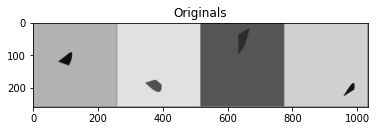

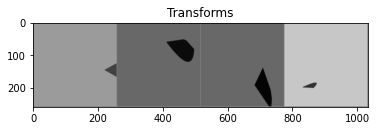

Transform parameters
tensor([0.7172, 0.4449, 0.4826, 0.5029, 0.5029], dtype=torch.float64)
tensor([0.6224, 0.6711, 0.4828, 0.5035, 0.5035], dtype=torch.float64)
tensor([0.6708, 0.2817, 0.5672, 0.5029, 0.5029], dtype=torch.float64)
tensor([0.3633, 0.5635, 0.4313, 0.5017, 0.5017], dtype=torch.float64)


In [ ]:
# def plotGrayScale(tensor, title):
#   tensor = tensor / 2 + 0.5     # unnormalize
#   npimg = tensor.numpy()
#   plt.imshow(np.transpose(npimg, (1, 2, 0)))
#   plt.title(title)
#   # plt.show()

dataiter = iter(trainloader)
images, images_t,  labels = dataiter.next()
print(labels)

# show images
plotGrayScale(torchvision.utils.make_grid(images), "Originals")
plt.show()
plotGrayScale(torchvision.utils.make_grid(images_t), "Transforms")
plt.show()
print(f'Transform parameters')
for label in labels:
  print(label)


## AffineNet CNN

In [13]:
# PReLU = nn.PReLU().cuda()
class AffineNet(nn.Module):
  def __init__(self,num_classes=5,activation='ReLU', batchNorm=False):
    super(AffineNet,self).__init__()

    if activation == 'ReLU':
      print('Using ReLU activation')
      self.activation = nn.ReLU(inplace=True)
    elif activation == 'PReLU':
      print('Using PReLU activation')
      self.activation = nn.PReLU()

    self.batchNorm = batchNorm

    # self.activation = nn.PRelU()
    if self.batchNorm:
      print('Using BatchNorm2D')
      self.feature_extraction = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=96,kernel_size=11,stride=4,padding=2,bias=False),
        nn.BatchNorm2d(96),
        self.activation,
        nn.MaxPool2d(kernel_size=3,stride=2,padding=0),

        nn.Conv2d(in_channels=96,out_channels=192,kernel_size=5,stride=1,padding=2,bias=False),
        nn.BatchNorm2d(192),
        self.activation,
        nn.MaxPool2d(kernel_size=3,stride=2,padding=0),

        nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(384),
        self.activation,

        nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(256),
        self.activation,
    
        nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(256),
        self.activation,
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
      )
    else:
      self.feature_extraction = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=96,kernel_size=11,stride=4,padding=2,bias=False),
        self.activation,
        nn.MaxPool2d(kernel_size=3,stride=2,padding=0),

        nn.Conv2d(in_channels=96,out_channels=192,kernel_size=5,stride=1,padding=2,bias=False),
        self.activation,
        nn.MaxPool2d(kernel_size=3,stride=2,padding=0),

        nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,stride=1,padding=1,bias=False),
        self.activation,

        nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
        self.activation,
    
        nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
        self.activation,
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
      )

    self.classifier = nn.Sequential(
      nn.Dropout(p=0.5),
      nn.Linear(in_features=25088,out_features=9216),

      self.activation,
      nn.Dropout(p=0.5),
      nn.Linear(in_features=9216,out_features=4096),
      self.activation,

      nn.Dropout(p=0.5),
      nn.Linear(in_features=4096, out_features=2048),
      self.activation,

      nn.Dropout(p=0.5),
      nn.Linear(in_features=2048, out_features=1024),
      self.activation,
      nn.Linear(in_features=1024, out_features=num_classes),
    )
  def forward(self, x1, x2):
    x1 = self.feature_extraction(x1)
    x2 = self.feature_extraction(x2)
    x = torch.cat((x1, x2), 1)
    # x = x.view(x.size(0),256*6*6)
    x = x.view(x.size(0),-1)
    x = self.classifier(x)
    return x


## Using ReLu activation

In [11]:
# net = AffineNet(activation='PReLU')
net = AffineNet()

print('---------- Network initialized -------------')
num_params = 0
for param in net.parameters():
  num_params += param.numel()
print('[Network] Total number of parameters : %.3f M' % (num_params / 1e6))
print('-----------------------------------------------')

if torch.cuda.is_available():
  print(f'GPU : {torch.cuda.get_device_name(0)}')
  cuda0 = torch.device('cuda:0')
  net.cuda()

NameError: ignored

In [ ]:
#Opimizer
criterion = torch.nn.L1Loss(reduction='sum').to(cuda0)
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))

myI = 0
channels = 2
iterations = []
losses = []

start_time = time.time()

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
      
        batch_imgs, batch_imgs_t, labels = data

        optimizer.zero_grad()

        # forward + backward + optimize
        batch_imgs = batch_imgs.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
        batch_imgs_t = batch_imgs_t.to(device=cuda0, dtype=torch.float)
        # inputs = inputs.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
        labels = labels.to(device=cuda0, dtype=torch.float)

        outputs = net(batch_imgs, batch_imgs_t)

        # outputs = outputs.reshape((5))
        loss_dx = criterion(outputs[:, 0], labels[:, 0])
        loss_dy = criterion(outputs[:, 1], labels[:, 1])
        loss_theta = criterion(outputs[:, 2], labels[:, 2])
        loss_sx = criterion(outputs[:, 3], labels[:, 3])
        loss_sy = criterion(outputs[:, 4], labels[:, 4])

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print(f'epoch = {epoch}, minibatch = {i}, loss = {loss.item()}')
        myI += 1
        
        if myI % 3000 == 2999:
          print('saving model')
          PATH = os.path.join(PATH_TO_MODELS, f'm_{epoch}_{running_loss/10}.pth')
          torch.save(net.state_dict(), PATH)

        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            print(f'dx loss = {loss_dx.item()}')
            print(f'dy loss = {loss_dy.item()}')
            print(f'theta loss = {loss_theta.item()}')
            print(f'sx loss = {loss_sx.item()}')
            print(f'sy loss = {loss_sy.item()}')
            print('-----------------------------')
            iterations.append(myI)
            losses.append(running_loss/10)
            running_loss = 0.0


stop_time = time.time()
print('Finished Training')
print(f'Training took: {stop_time-start_time} s')
# print("--- %s seconds ---" % (time.time() - start_time))

[1,    10] loss: 32.708
dx loss = 5.996459007263184
dy loss = 6.120737075805664
theta loss = 12.389619827270508
sx loss = 6.338009357452393
sy loss = 5.815479278564453
-----------------------------
[1,    20] loss: 17.873
dx loss = 1.6246957778930664
dy loss = 1.52964448928833
theta loss = 3.0054755210876465
sx loss = 1.288147211074829
sy loss = 1.8096370697021484
-----------------------------
[1,    30] loss: 11.958
dx loss = 1.4756691455841064
dy loss = 1.8923006057739258
theta loss = 3.674180507659912
sx loss = 2.34442138671875
sy loss = 2.0535755157470703
-----------------------------
[2,    10] loss: 10.559
dx loss = 1.406099557876587
dy loss = 1.1809788942337036
theta loss = 2.095189094543457
sx loss = 1.1917457580566406
sy loss = 1.2940760850906372
-----------------------------
[2,    20] loss: 9.609
dx loss = 1.208104133605957
dy loss = 1.15867018699646
theta loss = 3.7566962242126465
sx loss = 1.4334685802459717
sy loss = 1.548383355140686
-----------------------------
[2,    

## Using PReLU activation

In [48]:
net = AffineNet(activation='PReLU')
# net = AffineNet()

print('---------- Network initialized -------------')
num_params = 0
for param in net.parameters():
  num_params += param.numel()
print('[Network] Total number of parameters : %.3f M' % (num_params / 1e6))
print('-----------------------------------------------')

if torch.cuda.is_available():
  print(f'GPU : {torch.cuda.get_device_name(0)}')
  cuda0 = torch.device('cuda:0')
  net.cuda()

Using PReLU activation
---------- Network initialized -------------
[Network] Total number of parameters : 282.078 M
-----------------------------------------------
GPU : Tesla P100-PCIE-16GB


In [16]:

#Opimizer

optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))
criterion = torch.nn.L1Loss(reduction='sum').to(cuda0)

myI = 0
channels = 2
iterations = []
losses = []

maxEpoch = 2
maxIter = (len(affine_dataset)/batch_size)*maxEpoch
print(f'maxIter = {maxIter}')
start_time = time.time()

for epoch in range(maxEpoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):

        # batch_time_start = time.time()

        batch_imgs, batch_imgs_t, labels = data

        optimizer.zero_grad()

        # forward + backward + optimize
        batch_imgs = batch_imgs.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
        batch_imgs_t = batch_imgs_t.to(device=cuda0, dtype=torch.float)
        # inputs = inputs.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
        labels = labels.to(device=cuda0, dtype=torch.float)

        outputs = net(batch_imgs, batch_imgs_t)

        # outputs = outputs.reshape((5))
        loss_dx = criterion(outputs[:, 0], labels[:, 0])
        loss_dy = criterion(outputs[:, 1], labels[:, 1])
        loss_theta = criterion(outputs[:, 2], labels[:, 2])
        loss_sx = criterion(outputs[:, 3], labels[:, 3])
        loss_sy = criterion(outputs[:, 4], labels[:, 4])

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print(f'epoch = {epoch}, minibatch = {i}, loss = {loss.item()}')
        myI += 1
        
        if i % 30 == 29:
          print('saving model')
          PATH = os.path.join(PATH_TO_MODELS, f'm_{epoch}_{running_loss/10}.pth')
          torch.save(net.state_dict(), PATH)

        if i % 10 == 9:    # print every 10 mini-batches
            print('-----------------------------')
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            print(f'dx loss = {loss_dx.item()}')
            print(f'dy loss = {loss_dy.item()}')
            print(f'theta loss = {loss_theta.item()}')
            print(f'sx loss = {loss_sx.item()}')
            print(f'sy loss = {loss_sy.item()}')
            avg_iter_time = (time.time()-start_time)/myI
            print(f'Average iter time = {avg_iter_time} (s)')
            # print(f'ETA = {avg_iter_time*(maxIter - myI)} (s)')
            print('-----------------------------')
            iterations.append(myI)
            losses.append(running_loss/10)
            running_loss = 0.0

        avg_iter_time = (time.time()-start_time)/myI
        print(f'ETA = {avg_iter_time*(maxIter - myI)} (s)')
        # batch_time_stop = time.time()

stop_time = time.time()
print('Finished Training')
print(f'Training took: {stop_time-start_time} s')
# print("--- %s seconds ---" % (time.time() - start_time))

maxIter = 302.390625
ETA = 47059.35490434617 (s)
ETA = 43472.528501274064 (s)
ETA = 41998.28892538324 (s)
ETA = 41067.24959054403 (s)
ETA = 40570.74596161321 (s)
ETA = 40024.142078390345 (s)
ETA = 39471.9551549985 (s)
ETA = 39444.65101748379 (s)
ETA = 39031.93035888175 (s)
-----------------------------
[1,    10] loss: 704.742
dx loss = 283.3526916503906
dy loss = 296.0252685546875
theta loss = 103.89375305175781
sx loss = 1.9353874921798706
sy loss = 2.0702037811279297
Average iter time = 132.80089173316955 (s)
-----------------------------
ETA = 38829.737309895456 (s)
ETA = 38385.112438599834 (s)
ETA = 37993.26860855799 (s)
ETA = 37765.214085407264 (s)
ETA = 37536.026305272375 (s)
ETA = 37179.024993516505 (s)
ETA = 36988.20387046714 (s)
ETA = 36817.274927941755 (s)
ETA = 36551.820291405544 (s)
ETA = 36312.13586468426 (s)
-----------------------------
[1,    20] loss: 631.286
dx loss = 187.35684204101562
dy loss = 200.5884552001953
theta loss = 112.7342529296875
sx loss = 16.518371582

Text(0.5, 1.0, 'Training loss')

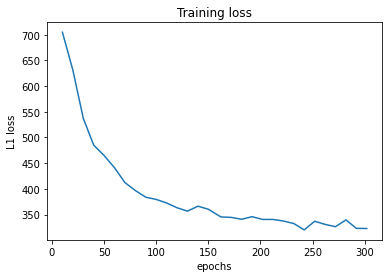

In [17]:
plt.plot(iterations, losses)
plt.xlabel('epochs')
plt.ylabel('L1 loss')
plt.title("Training loss")

## Saving the latest

In [23]:
PATH = os.path.join(PATH_TO_MODELS, f'affineNet2.0.pth')
torch.save(net.state_dict(), PATH)

## Loading the model

In [15]:
PATH = os.path.join(PATH_TO_MODELS, f'affineNet3.0.pth')
net = AffineNet(activation='PReLU')
net.load_state_dict(torch.load(PATH))
if torch.cuda.is_available():
  print(f'GPU : {torch.cuda.get_device_name(0)}')
  cuda0 = torch.device('cuda:0')
  net.cuda()

Using PReLU activation
GPU : Tesla P100-PCIE-16GB


# Trainin again (last model is starting point)

In [50]:

#Opimizer

optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))
criterion = torch.nn.L1Loss(reduction='sum').to(cuda0)

myI = 0
channels = 2
iterations = []
losses = []

maxEpoch = 2
maxIter = (len(affine_dataset)/batch_size)*maxEpoch
print(f'maxIter = {maxIter}')
start_time = time.time()

for epoch in range(maxEpoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):

        # batch_time_start = time.time()

        batch_imgs, batch_imgs_t, labels = data

        optimizer.zero_grad()

        # forward + backward + optimize
        batch_imgs = batch_imgs.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
        batch_imgs_t = batch_imgs_t.to(device=cuda0, dtype=torch.float)
        # inputs = inputs.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
        labels = labels.to(device=cuda0, dtype=torch.float)

        outputs = net(batch_imgs, batch_imgs_t)

        # outputs = outputs.reshape((5))
        loss_dx = criterion(outputs[:, 0], labels[:, 0])
        loss_dy = criterion(outputs[:, 1], labels[:, 1])
        loss_theta = criterion(outputs[:, 2], labels[:, 2])
        loss_sx = criterion(outputs[:, 3], labels[:, 3])
        loss_sy = criterion(outputs[:, 4], labels[:, 4])

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print(f'epoch = {epoch}, minibatch = {i}, loss = {loss.item()}')
        myI += 1
        
        if i % 30 == 29:
          print('saving model')
          PATH = os.path.join(PATH_TO_MODELS, f'm_{epoch}_{running_loss/10}.pth')
          torch.save(net.state_dict(), PATH)

        if i % 10 == 9:    # print every 10 mini-batches
            print('-----------------------------')
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            print(f'dx loss = {loss_dx.item()}')
            print(f'dy loss = {loss_dy.item()}')
            print(f'theta loss = {loss_theta.item()}')
            print(f'sx loss = {loss_sx.item()}')
            print(f'sy loss = {loss_sy.item()}')
            avg_iter_time = (time.time()-start_time)/myI
            print(f'Average iter time = {avg_iter_time} (s)')
            # print(f'ETA = {avg_iter_time*(maxIter - myI)} (s)')
            print('-----------------------------')
            iterations.append(myI)
            losses.append(running_loss/10)
            running_loss = 0.0

        avg_iter_time = (time.time()-start_time)/myI
        print(f'ETA = {avg_iter_time*(maxIter - myI)} (s)')
        # batch_time_stop = time.time()

stop_time = time.time()
print('Finished Training')
print(f'Training took: {stop_time-start_time} s')
# print("--- %s seconds ---" % (time.time() - start_time))

maxIter = 302.390625
ETA = 30628.2328934893 (s)
ETA = 29327.555221226066 (s)
ETA = 28166.84535852447 (s)
ETA = 27475.718394846655 (s)
ETA = 27033.97925094366 (s)
ETA = 26750.724398449063 (s)
ETA = 26454.67369472608 (s)
ETA = 26601.605280127376 (s)
ETA = 26327.455393799893 (s)
-----------------------------
[1,    10] loss: 364.735
dx loss = 112.0427474975586
dy loss = 114.13622283935547
theta loss = 106.49256896972656
sx loss = 5.565598487854004
sy loss = 2.778876304626465
Average iter time = 90.08231821060181 (s)
-----------------------------
ETA = 26339.22689852342 (s)
ETA = 26203.806009611282 (s)
ETA = 26017.345123034902 (s)
ETA = 25921.0470283553 (s)
ETA = 25786.138991554402 (s)
ETA = 25725.84827625081 (s)
ETA = 25867.553045670036 (s)
ETA = 25688.730218518966 (s)
ETA = 25495.846969249968 (s)
ETA = 25440.637700836323 (s)
-----------------------------
[1,    20] loss: 321.091
dx loss = 91.673828125
dy loss = 103.70885467529297
theta loss = 87.10516357421875
sx loss = 3.425389289855957

## Training loss plot

Text(0.5, 1.0, 'Training loss')

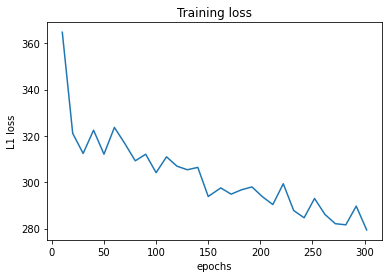

In [51]:
plt.plot(iterations, losses)
plt.xlabel('epochs')
plt.ylabel('L1 loss')
plt.title("Training loss")

## Save latest model

In [58]:
PATH = os.path.join(PATH_TO_MODELS, f'affineNet3.0.pth')
torch.save(net.state_dict(), PATH)

# Testing

In [17]:
TEST_IMGS_ROT_O = '/content/SMD_V3/SMD_V3_TESTER_ROT/input/original'
TEST_IMGS_ROT_T = '/content/SMD_V3/SMD_V3_TESTER_ROT/input/transformed'
TEST_IMGS_ROT_L = '/content/SMD_V3/SMD_V3_TESTER_ROT/labels'

TEST_IMGS_SCAL_O = '/content/SMD_V3/SMD_V3_TESTER_SCAL/input/original'
TEST_IMGS_SCAL_T = '/content/SMD_V3/SMD_V3_TESTER_SCAL/input/transformed'
TEST_IMGS_SCAL_L = '/content/SMD_V3/SMD_V3_TESTER_SCAL/labels'

TEST_IMGS_TRANS_O = '/content/SMD_V3/SMD_V3_TESTER_TRANS/input/original'
TEST_IMGS_TRANS_T = '/content/SMD_V3/SMD_V3_TESTER_TRANS/input/transformed'
TEST_IMGS_TRANS_L = '/content/SMD_V3/SMD_V3_TESTER_TRANS/labels'

TEST_IMGS_O = '/content/SMD_V3/SMD_V3_TESTER_COMB/input/original'
TEST_IMGS_T = '/content/SMD_V3/SMD_V3_TESTER_COMB/input/transformed'
TEST_IMGS_L = '/content/SMD_V3/SMD_V3_TESTER_COMB/labels'

## Loading test data

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

#w gaussian noise
transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Grayscale(1),
                    transforms.Resize([IMG_WIDTH, IMG_HEIGHT]),
                    transforms.ColorJitter(brightness=(0.3,1), contrast=(0.3,1)),
                    transforms.ToTensor(),
                    AddGaussianNoise(0.,0.2),
                    transforms.Normalize(0.5, 0.5)])
#w/o Gaussian noise
# transform = transforms.Compose([
#                     transforms.ToPILImage(),
#                     transforms.Grayscale(1),
#                     transforms.Resize([IMG_WIDTH, IMG_HEIGHT]),
#                     transforms.ColorJitter(brightness=(0.3,1), contrast=(0.3,1)),
#                     transforms.ToTensor(),
#                     transforms.Normalize(0.5, 0.5)])

In [18]:
batch_size = 4
rot_test_dataset = AffineDataset(TEST_IMGS_ROT_O, TEST_IMGS_ROT_T, TEST_IMGS_ROT_L, transform=transform, norm_out=True)
scal_test_dataset = AffineDataset(TEST_IMGS_SCAL_O, TEST_IMGS_SCAL_T, TEST_IMGS_SCAL_L, transform=transform, norm_out=True)
trans_test_dataset = AffineDataset(TEST_IMGS_TRANS_O, TEST_IMGS_TRANS_T, TEST_IMGS_TRANS_L, transform=transform, norm_out=True)
test_dataset = AffineDataset(TEST_IMGS_O, TEST_IMGS_T, TEST_IMGS_L, transform=transform, norm_out=True)

print(f'Rot test dataset size: {len(rot_test_dataset)}')
print(f'Scal test dataset size: {len(scal_test_dataset)}')
print(f'Trans test dataset size: {len(trans_test_dataset)}')

testloader_rot = DataLoader(rot_test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
testloader_scal = DataLoader(scal_test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
testloader_trans = DataLoader(trans_test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

Rot test dataset size: 483
Scal test dataset size: 487
Trans test dataset size: 480


## Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


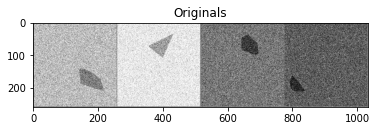

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


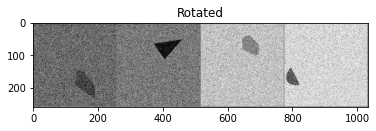

Transform parameters (ROT)
tensor([  0.0000,   0.0000, -17.3879,   1.0000,   1.0000], dtype=torch.float64)
tensor([  0.0000,   0.0000, -17.4705,   1.0000,   1.0000], dtype=torch.float64)
tensor([ 0.0000,  0.0000, -2.3253,  1.0000,  1.0000], dtype=torch.float64)
tensor([  0.0000,   0.0000, -12.9314,   1.0000,   1.0000], dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


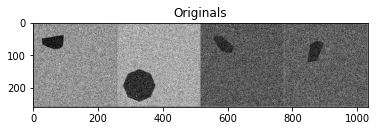

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


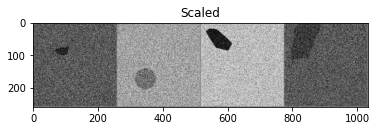

Transform parameters (SCAL)
tensor([0.0000, 0.0000, 0.0000, 0.5981, 0.5981], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0000, 0.6818, 0.6818], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0000, 1.2509, 1.2509], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0000, 1.9452, 1.9452], dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


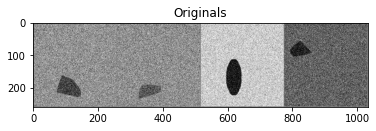

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


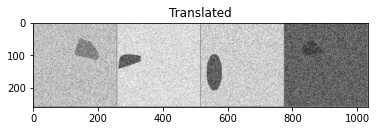

Transform parameters (TRANS)
tensor([ 54.9371, 114.4009,   0.0000,   1.0000,   1.0000], dtype=torch.float64)
tensor([-62.1512,  92.3918,   0.0000,   1.0000,   1.0000], dtype=torch.float64)
tensor([-60.4504,  15.1579,   0.0000,   1.0000,   1.0000], dtype=torch.float64)
tensor([35.2046,  3.6176,  0.0000,  1.0000,  1.0000], dtype=torch.float64)


In [ ]:
dataiter = iter(testloader_rot)
images, images_t,  labels = dataiter.next()
plotGrayScale(torchvision.utils.make_grid(images), "Originals")
plt.show()
plotGrayScale(torchvision.utils.make_grid(images_t), "Rotated")
plt.show()
print(f'Transform parameters (ROT)')
for label in labels:
  print(label)

dataiter = iter(testloader_scal)
images, images_t,  labels = dataiter.next()
# print(labels)
plotGrayScale(torchvision.utils.make_grid(images), "Originals")
plt.show()
plotGrayScale(torchvision.utils.make_grid(images_t), "Scaled")
plt.show()
print(f'Transform parameters (SCAL)')
for label in labels:
  print(label)

dataiter = iter(testloader_trans)
images, images_t,  labels = dataiter.next()
# print(labels)
plotGrayScale(torchvision.utils.make_grid(images), "Originals")
plt.show()
plotGrayScale(torchvision.utils.make_grid(images_t), "Translated")
plt.show()
print(f'Transform parameters (TRANS)')
for label in labels:
  print(label)

# Test Performance with Gaussian noise

In [15]:
def testModel(dataloader):
  running_loss = 0.0
  avg_infer_time = 0.0
  criterion = torch.nn.L1Loss(reduction='sum').to(cuda0)

  for i, data in enumerate(dataloader):

      batch_imgs, batch_imgs_t, labels = data

        # forward 
      batch_imgs = batch_imgs.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
      batch_imgs_t = batch_imgs_t.to(device=cuda0, dtype=torch.float)
      labels = labels.to(device=cuda0, dtype=torch.float)
      infer_start = time.time()
      outputs = net(batch_imgs, batch_imgs_t)
      infer_end = time.time()
      loss = criterion(outputs, labels)
      running_loss += loss.item()
      avg_infer_time += ((infer_end-infer_start)/batch_size)
      if i % 20 == 19:
        print(f'Average Test loss = {running_loss/i}')
        print(f'Average Infer time = {avg_infer_time/i}')
        print('----------------------------------------')

  return (running_loss/i), (avg_infer_time/i)

## Rotated only

In [29]:
loss, infertime = testModel(testloader_rot)
print(f'Average Rot Test loss = {loss}')
print(f'Average Infer time = {infertime}')

Average Test loss = 7.2611956345407584
Average Infer time = 0.0008866630102458753
----------------------------------------
Average Test loss = 7.211859727517153
Average Infer time = 0.0008826240515097594
----------------------------------------


KeyboardInterrupt: ignored

## Scaling only

In [ ]:
  loss, infertime = testModel(testloader_scal)
  print(f'Average scaling test loss = {loss}')
  print(f'Average Infer time = {infertime}')

Average Test loss = 3.6791887220583464
Average Infer time = 0.0009767726847999974
----------------------------------------
Average Test loss = 3.510168873346769
Average Infer time = 0.0007412617023174579
----------------------------------------


## Translation only

In [18]:
loss, infertime = testModel(testloader_trans)
print(f'Average translation test loss = {loss}')
print(f'Average Infer time = {infertime}')

Average Test loss = 7.077142539777253
Average Infer time = 0.0010463689502916839
----------------------------------------
Average Test loss = 7.30209538875482
Average Infer time = 0.0007771513400933681
----------------------------------------


KeyboardInterrupt: ignored

## Pred Vs. True

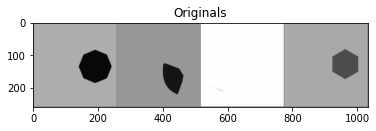

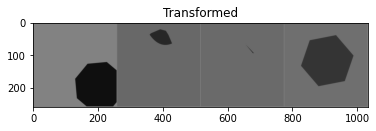

Transform parameters (COMB)
Loss = 219.666748046875
True = tensor([ -8.6213, -19.5570, -17.3438,   1.5287,   1.5287], device='cuda:0')
Pred = tensor([-23.2999, -31.2451,  -9.9829,   0.9668,   1.1246], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([-47.7991, 116.0339,  43.8518,   0.7114,   0.7114], device='cuda:0')
Pred = tensor([-32.6467, 113.6403,  11.1930,   0.8107,   0.6217], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([127.2337,  85.2221, -26.4265,   0.8993,   0.8993], device='cuda:0')
Pred = tensor([ 91.3105, 106.6569,   4.6732,   1.5803,   2.1639], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([-54.6476,  25.1280, -19.0928,   1.7952,   1.7952], device='cuda:0')
Pred = tensor([-54.1240,   4.4315,   2.7099,   1.3423,   1.0949], device='cuda:0',
       grad_fn=<UnbindBackward0>)


In [60]:
# def unnormalize(x):
#   return (x*(2*256.0) - 256.0)

def unnormalize(x, x1 = -10.0, y1 = -256.0, x2 = 10.0, y2 = 256.0):
  return y1+((y2-y1)/(x2-x1))*(x-x1)

dataiter = iter(testloader)
images, images_t,  labels = dataiter.next()

plotGrayScale(torchvision.utils.make_grid(images), "Originals")
plt.show()
plotGrayScale(torchvision.utils.make_grid(images_t), "Transformed")
plt.show()
print(f'Transform parameters (COMB)')

images = images.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
images_t = images_t.to(device=cuda0, dtype=torch.float)
# labels = labels.to(device=cuda0, dtype=torch.float)
#Inference
outputs = net(images, images_t)

#Unnormalize
outputs = unnormalize(outputs)
labels = unnormalize(labels)

labels = labels.to(device=cuda0, dtype=torch.float)
criterion = torch.nn.L1Loss(reduction='sum').to(cuda0)
print(f'Loss = {criterion(outputs, labels)}')

for label, output in zip (labels, outputs):
  print(f'True = {label}')
  print(f'Pred = {output}')


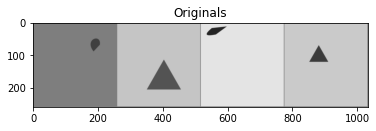

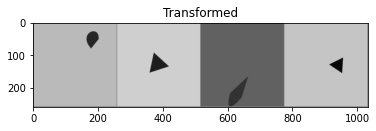

Transform parameters (COMB)
Loss = 233.12258911132812
True = tensor([-16.1131,  -6.8840,   4.4153,   1.3139,   1.3139], device='cuda:0')
Pred = tensor([-11.3854,  45.5279,   8.7282,   1.3303,   0.8763], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([-35.7398,  41.9610,  17.8294,   0.5960,   0.5960], device='cuda:0')
Pred = tensor([-21.1481,  40.5418,   1.1711,   1.0123,   0.9307], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([118.7991, -86.5326,  36.5279,   1.6464,   1.6464], device='cuda:0')
Pred = tensor([ 102.6894, -148.9716,   17.1516,    1.8988,    0.4898],
       device='cuda:0', grad_fn=<UnbindBackward0>)
True = tensor([ 50.9297, -35.2209, -33.6083,   0.8135,   0.8135], device='cuda:0')
Pred = tensor([ 49.3335, -31.5686,  -0.9882,   1.1293,   1.0909], device='cuda:0',
       grad_fn=<UnbindBackward0>)


In [21]:
# def unnormalize(x):
#   return (x*(2*256.0) - 256.0)

def unnormalize(x, x1 = -10.0, y1 = -256.0, x2 = 10.0, y2 = 256.0):
  return y1+((y2-y1)/(x2-x1))*(x-x1)

dataiter = iter(testloader)
images, images_t,  labels = dataiter.next()

plotGrayScale(torchvision.utils.make_grid(images), "Originals")
plt.show()
plotGrayScale(torchvision.utils.make_grid(images_t), "Transformed")
plt.show()
print(f'Transform parameters (COMB)')

images = images.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
images_t = images_t.to(device=cuda0, dtype=torch.float)
# labels = labels.to(device=cuda0, dtype=torch.float)
#Inference
outputs = net(images, images_t)

#Unnormalize
outputs = unnormalize(outputs)
labels = unnormalize(labels)

labels = labels.to(device=cuda0, dtype=torch.float)
criterion = torch.nn.L1Loss(reduction='sum').to(cuda0)
print(f'Loss = {criterion(outputs, labels)}')

for label, output in zip (labels, outputs):
  print(f'True = {label}')
  print(f'Pred = {output}')

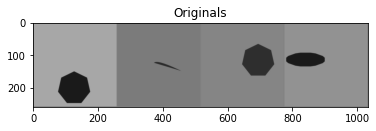

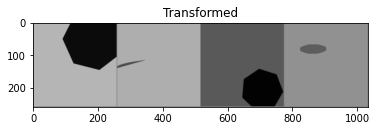

Transform parameters (COMB)
Loss = 199.52175903320312
True = tensor([ 50.6144, 109.9786, -14.1510,   1.8599,   1.8599], device='cuda:0')
Pred = tensor([ 19.3897, 113.9544,   6.0359,   1.1176,   1.4070], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([-103.8923,   -8.0686,   32.1030,    1.1318,    1.1318],
       device='cuda:0')
Pred = tensor([-88.5992,  10.5769,   0.4674,   1.3966,   0.9447], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([  0.7487, -79.5043,   8.0918,   1.2833,   1.2833], device='cuda:0')
Pred = tensor([-18.4645, -71.3351, -14.7997,   1.5790,   1.2126], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([ 5.5122, 55.2659,  0.7854,  0.6794,  0.6794], device='cuda:0')
Pred = tensor([ 8.7467, 38.5009, -4.6319,  0.9980,  1.2166], device='cuda:0',
       grad_fn=<UnbindBackward0>)


In [23]:
# def unnormalize(x):
#   return (x*(2*256.0) - 256.0)

def unnormalize(x, x1 = -10.0, y1 = -256.0, x2 = 10.0, y2 = 256.0):
  return y1+((y2-y1)/(x2-x1))*(x-x1)

dataiter = iter(testloader)
images, images_t,  labels = dataiter.next()

plotGrayScale(torchvision.utils.make_grid(images), "Originals")
plt.show()
plotGrayScale(torchvision.utils.make_grid(images_t), "Transformed")
plt.show()
print(f'Transform parameters (COMB)')

images = images.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
images_t = images_t.to(device=cuda0, dtype=torch.float)
# labels = labels.to(device=cuda0, dtype=torch.float)
#Inference
outputs = net(images, images_t)

#Unnormalize
outputs = unnormalize(outputs)
labels = unnormalize(labels)

labels = labels.to(device=cuda0, dtype=torch.float)
criterion = torch.nn.L1Loss(reduction='sum').to(cuda0)
print(f'Loss = {criterion(outputs, labels)}')

for label, output in zip (labels, outputs):
  print(f'True = {label}')
  print(f'Pred = {output}')

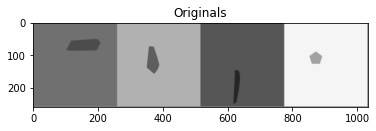

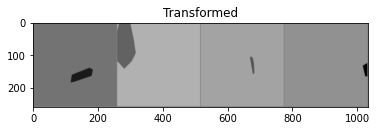

Transform parameters (COMB)
Loss = 165.32635498046875
True = tensor([  20.1776, -108.7789,   17.9128,    0.7302,    0.7302],
       device='cuda:0')
Pred = tensor([  2.4170, -92.7646,  -3.0063,   0.9521,   1.2301], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([-39.8946,  20.1329,  -6.5403,   1.8602,   1.8602], device='cuda:0')
Pred = tensor([-64.4527,  20.7924,   3.5362,   1.2607,   1.2434], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([64.1619, 66.0837, 12.7090,  0.5150,  0.5150], device='cuda:0')
Pred = tensor([37.2704, 76.2449,  5.3932,  0.8057,  1.1728], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([133.1293, -32.6360,  -5.0397,   1.3464,   1.3464], device='cuda:0')
Pred = tensor([123.2027, -42.5953,   0.8855,   2.4895,   2.4751], device='cuda:0',
       grad_fn=<UnbindBackward0>)


In [24]:
# def unnormalize(x):
#   return (x*(2*256.0) - 256.0)

def unnormalize(x, x1 = -10.0, y1 = -256.0, x2 = 10.0, y2 = 256.0):
  return y1+((y2-y1)/(x2-x1))*(x-x1)

dataiter = iter(testloader)
images, images_t,  labels = dataiter.next()

plotGrayScale(torchvision.utils.make_grid(images), "Originals")
plt.show()
plotGrayScale(torchvision.utils.make_grid(images_t), "Transformed")
plt.show()
print(f'Transform parameters (COMB)')

images = images.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
images_t = images_t.to(device=cuda0, dtype=torch.float)
# labels = labels.to(device=cuda0, dtype=torch.float)
#Inference
outputs = net(images, images_t)

#Unnormalize
outputs = unnormalize(outputs)
labels = unnormalize(labels)

labels = labels.to(device=cuda0, dtype=torch.float)
criterion = torch.nn.L1Loss(reduction='sum').to(cuda0)
print(f'Loss = {criterion(outputs, labels)}')

for label, output in zip (labels, outputs):
  print(f'True = {label}')
  print(f'Pred = {output}')

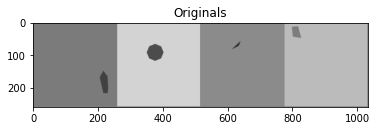

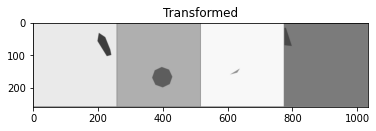

Transform parameters (COMB)
Loss = 103.69886779785156
True = tensor([-22.3327,  76.7089,  19.0879,   1.1080,   1.1080], device='cuda:0')
Pred = tensor([-20.3708,  64.3033,  12.7321,   1.7176,   1.4083], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([ 21.8458, -68.7361,   2.8097,   1.2038,   1.2038], device='cuda:0')
Pred = tensor([ 18.6714, -80.3208,  -0.5460,   1.5595,   1.0395], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([-17.5877, -84.6005, -11.7343,   0.9395,   0.9395], device='cuda:0')
Pred = tensor([-18.1083, -85.2915,  10.0865,   1.3206,   0.7599], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([ 13.4003, -41.6188,   2.7347,   1.5817,   1.5817], device='cuda:0')
Pred = tensor([  5.4490, -12.4533,   4.9491,   2.0750,   1.5953], device='cuda:0',
       grad_fn=<UnbindBackward0>)


In [26]:
# def unnormalize(x):
#   return (x*(2*256.0) - 256.0)

def unnormalize(x, x1 = -10.0, y1 = -256.0, x2 = 10.0, y2 = 256.0):
  return y1+((y2-y1)/(x2-x1))*(x-x1)

dataiter = iter(testloader)
images, images_t,  labels = dataiter.next()

plotGrayScale(torchvision.utils.make_grid(images), "Originals")
plt.show()
plotGrayScale(torchvision.utils.make_grid(images_t), "Transformed")
plt.show()
print(f'Transform parameters (COMB)')

images = images.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
images_t = images_t.to(device=cuda0, dtype=torch.float)
# labels = labels.to(device=cuda0, dtype=torch.float)
#Inference
outputs = net(images, images_t)

#Unnormalize
outputs = unnormalize(outputs)
labels = unnormalize(labels)

labels = labels.to(device=cuda0, dtype=torch.float)
criterion = torch.nn.L1Loss(reduction='sum').to(cuda0)
print(f'Loss = {criterion(outputs, labels)}')

for label, output in zip (labels, outputs):
  print(f'True = {label}')
  print(f'Pred = {output}')
  

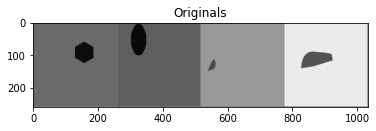

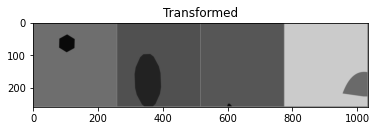

Transform parameters (COMB)
Loss = 112.7411117553711
True = tensor([-59.5556,  41.6092,  -1.5095,   0.8285,   0.8285], device='cuda:0')
Pred = tensor([-52.3512,  37.0609,   8.1613,   0.8038,   0.9354], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([  45.1904, -102.4470,    2.2196,    1.7031,    1.7031],
       device='cuda:0')
Pred = tensor([ 42.3098, -97.6172,  20.9597,   0.7912,   0.9899], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([ 54.9780, -56.0050,  26.9371,   1.4517,   1.4517], device='cuda:0')
Pred = tensor([ 54.0228, -55.0046,  23.3636,   2.0327,   2.0663], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([106.8904, -64.0767, -16.9476,   1.6830,   1.6830], device='cuda:0')
Pred = tensor([ 86.9176, -50.6665,   5.5228,   1.7828,   1.2506], device='cuda:0',
       grad_fn=<UnbindBackward0>)


In [32]:
def unnormalize(x, x1 = -10.0, y1 = -256.0, x2 = 10.0, y2 = 256.0):
  return y1+((y2-y1)/(x2-x1))*(x-x1)

dataiter = iter(testloader)
images, images_t,  labels = dataiter.next()

plotGrayScale(torchvision.utils.make_grid(images), "Originals")
plt.show()
plotGrayScale(torchvision.utils.make_grid(images_t), "Transformed")
plt.show()
print(f'Transform parameters (COMB)')

images = images.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
images_t = images_t.to(device=cuda0, dtype=torch.float)
# labels = labels.to(device=cuda0, dtype=torch.float)
#Inference
outputs = net(images, images_t)

#Unnormalize
outputs = unnormalize(outputs)
labels = unnormalize(labels)

labels = labels.to(device=cuda0, dtype=torch.float)
criterion = torch.nn.L1Loss(reduction='sum').to(cuda0)
print(f'Loss = {criterion(outputs, labels)}')

for label, output in zip (labels, outputs):
  print(f'True = {label}')
  print(f'Pred = {output}')
  

In [61]:
print(unnormalize(0.5011))
print(unnormalize(0.4542))

12.828159999999968
11.627520000000004


# Test Perf without gaussian noise

In [ ]:
#w/o Gaussian noise
transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Grayscale(1),
                    transforms.Resize([IMG_WIDTH, IMG_HEIGHT]),
                    transforms.ColorJitter(brightness=(0.3,1), contrast=(0.3,1)),
                    transforms.ToTensor(),
                    transforms.Normalize(0.5, 0.5)])
batch_size = 4
rot_test_dataset = AffineDataset(TEST_IMGS_ROT_O, TEST_IMGS_ROT_T, TEST_IMGS_ROT_L, transform=transform, norm_out=True)
scal_test_dataset = AffineDataset(TEST_IMGS_SCAL_O, TEST_IMGS_SCAL_T, TEST_IMGS_SCAL_L, transform=transform, norm_out=True)
trans_test_dataset = AffineDataset(TEST_IMGS_TRANS_O, TEST_IMGS_TRANS_T, TEST_IMGS_TRANS_L, transform=transform, norm_out=True)
test_dataset = AffineDataset(TEST_IMGS_O, TEST_IMGS_T, TEST_IMGS_L, transform=transform, norm_out=True)

print(f'Rot test dataset size: {len(rot_test_dataset)}')
print(f'Scal test dataset size: {len(scal_test_dataset)}')
print(f'Trans test dataset size: {len(trans_test_dataset)}')
print(f'Combined test dataset size: {len(test_dataset)}')

testloader_rot = DataLoader(rot_test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
testloader_scal = DataLoader(scal_test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
testloader_trans = DataLoader(trans_test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

testloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

Rot test dataset size: 483
Scal test dataset size: 487
Trans test dataset size: 480
Combined test dataset size: 10416


## Visualization

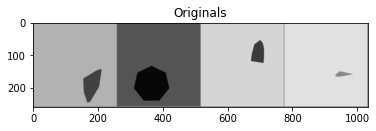

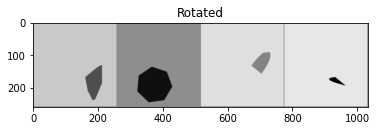

Transform parameters (ROT)
tensor([0.5000, 0.5000, 0.5162, 0.5020, 0.5020], dtype=torch.float64)
tensor([0.5000, 0.5000, 0.5151, 0.5020, 0.5020], dtype=torch.float64)
tensor([0.5000, 0.5000, 0.4427, 0.5020, 0.5020], dtype=torch.float64)
tensor([0.5000, 0.5000, 0.4464, 0.5020, 0.5020], dtype=torch.float64)


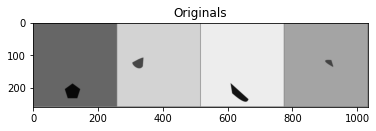

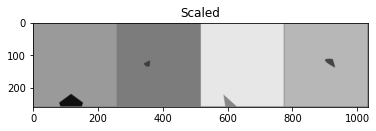

Transform parameters (SCAL)
tensor([0.5000, 0.5000, 0.5000, 0.5030, 0.5030], dtype=torch.float64)
tensor([0.5000, 0.5000, 0.5000, 0.5011, 0.5011], dtype=torch.float64)
tensor([0.5000, 0.5000, 0.5000, 0.5031, 0.5031], dtype=torch.float64)
tensor([0.5000, 0.5000, 0.5000, 0.5024, 0.5024], dtype=torch.float64)


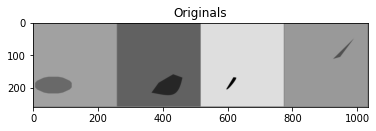

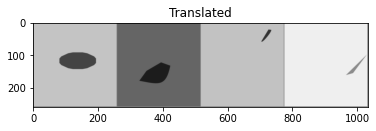

Transform parameters (TRANS)
tensor([0.6466, 0.6454, 0.5000, 0.5020, 0.5020], dtype=torch.float64)
tensor([0.4269, 0.5710, 0.5000, 0.5020, 0.5020], dtype=torch.float64)
tensor([0.7111, 0.7847, 0.5000, 0.5020, 0.5020], dtype=torch.float64)
tensor([0.5777, 0.4034, 0.5000, 0.5020, 0.5020], dtype=torch.float64)


In [ ]:
dataiter = iter(testloader_rot)
images, images_t,  labels = dataiter.next()
plotGrayScale(torchvision.utils.make_grid(images), "Originals")
plt.show()
plotGrayScale(torchvision.utils.make_grid(images_t), "Rotated")
plt.show()
print(f'Transform parameters (ROT)')
for label in labels:
  print(label)

dataiter = iter(testloader_scal)
images, images_t,  labels = dataiter.next()
# print(labels)
plotGrayScale(torchvision.utils.make_grid(images), "Originals")
plt.show()
plotGrayScale(torchvision.utils.make_grid(images_t), "Scaled")
plt.show()
print(f'Transform parameters (SCAL)')
for label in labels:
  print(label)

dataiter = iter(testloader_trans)
images, images_t,  labels = dataiter.next()
# print(labels)
plotGrayScale(torchvision.utils.make_grid(images), "Originals")
plt.show()
plotGrayScale(torchvision.utils.make_grid(images_t), "Translated")
plt.show()
print(f'Transform parameters (TRANS)')
for label in labels:
  print(label)

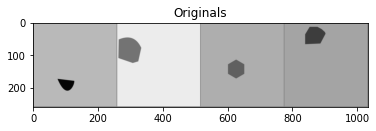

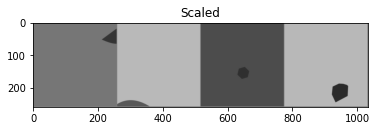

Transform parameters (SCAL)
tensor([0.6420, 0.7486, 0.5836, 0.5026, 0.5026], dtype=torch.float64)
tensor([0.6177, 0.3475, 0.5643, 0.5039, 0.5039], dtype=torch.float64)
tensor([0.5520, 0.4406, 0.4731, 0.5013, 0.5013], dtype=torch.float64)
tensor([0.7299, 0.1910, 0.5493, 0.5017, 0.5017], dtype=torch.float64)


In [ ]:
#Combined
dataiter = iter(testloader)
images, images_t,  labels = dataiter.next()
# print(labels)
plotGrayScale(torchvision.utils.make_grid(images), "Originals")
plt.show()
plotGrayScale(torchvision.utils.make_grid(images_t), "transfromed")
plt.show()
print(f'Transform parameters (SCAL)')
for label in labels:
  print(label)

## Combined

In [ ]:
loss, infertime = testModel(testloader)
print(f'Average scaling test loss = {loss}')
print(f'Average Infer time = {infertime}')

Average Test loss = 10.304847340834769
Average Infer time = 0.000559163720984208
----------------------------------------
Average Test loss = 9.495931808765118
Average Infer time = 0.0005348752706478804
----------------------------------------
Average Test loss = 9.403114132961985
Average Infer time = 0.0005366327398914402
----------------------------------------
Average Test loss = 9.31670341008826
Average Infer time = 0.0005368409277517585
----------------------------------------
Average Test loss = 9.447300251084144
Average Infer time = 0.000534227400115042
----------------------------------------
Average Test loss = 9.387257760312377
Average Infer time = 0.0005290152645912491
----------------------------------------
Average Test loss = 9.19889801354717
Average Infer time = 0.0005251945351525177
----------------------------------------
Average Test loss = 9.252872101165963
Average Infer time = 0.0005238997111530424
----------------------------------------
Average Test loss = 9.23631

In [3]:
import numpy as np

a = np.array([10.304847340834769, 9.495931808765118, 9.403114132961985, 9.31670341008826, 9.447300251084144, 9.387257760312377, 9.19889801354717, 9.252872101165963, 9.236311121359885, 9.169901107423868, 9.170975815759947, 9.276221522726274, 9.294952946740228,  9.325438569523527, 9.376059602335545, 9.377057531410625, 9.326176227821815, 9.33118152200967, 9.327603180761468, 9.337941308359882, 9.344011873729208, 9.344730614373434, 9.343198752767353, 9.33537640744159, 9.341010095099726, 9.341215116424104, 9.335112134855878, 9.32559614687777, 9.334659700248936, 9.331380300321248, 9.335823106516093])
np.mean(a)

9.357059984633803

## Scaling only

In [ ]:
loss, infertime = testModel(testloader_scal)
print(f'Average scaling test loss = {loss}')
print(f'Average Infer time = {infertime}')

Average Test loss = 0.5069076952181364
Average Infer time = 0.0008630187887894479
----------------------------------------
Average Test loss = 0.5222799533452743
Average Infer time = 0.0008005698521931967
----------------------------------------
Average Test loss = 0.5331670904563646
Average Infer time = 0.0007832969649363373
----------------------------------------
Average Test loss = 0.5294019677970982
Average Infer time = 0.0007911211327661442
----------------------------------------
Average Test loss = 0.5273912028230802
Average Infer time = 0.0007823506991068522
----------------------------------------
Average Test loss = 0.5243832231068811
Average Infer time = 0.0007745067612463687
----------------------------------------
Average scaling test loss = 0.5215392410755157
Average Infer time = 0.0007757810521716914


## Pred Vs. True

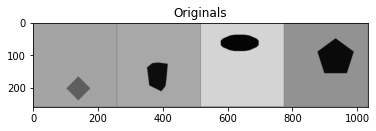

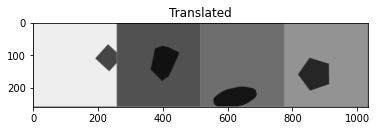

Transform parameters (COMB)
True = tensor([0.6541, 0.6772, 0.5054, 0.5022, 0.5022], dtype=torch.float64)
Pred = tensor([0.6067, 0.5756, 0.4357, 0.4406, 0.4481], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([0.5533, 0.5740, 0.4628, 0.5023, 0.5023], dtype=torch.float64)
Pred = tensor([0.4838, 0.6044, 0.5035, 0.5123, 0.4961], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([0.5048, 0.2075, 0.5242, 0.5022, 0.5022], dtype=torch.float64)
Pred = tensor([0.4350, 0.2171, 0.4624, 0.4655, 0.4708], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True = tensor([0.3853, 0.3778, 0.5368, 0.5017, 0.5017], dtype=torch.float64)
Pred = tensor([0.4043, 0.4199, 0.4712, 0.4767, 0.4716], device='cuda:0',
       grad_fn=<UnbindBackward0>)


In [ ]:
def unnormalize(x):
  return (x*(2*256.0) - 256.0)

net.cuda()
dataiter = iter(testloader)
images, images_t,  labels = dataiter.next()

plotGrayScale(torchvision.utils.make_grid(images), "Originals")
plt.show()
plotGrayScale(torchvision.utils.make_grid(images_t), "Translated")
plt.show()
print(f'Transform parameters (COMB)')

images = images.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
images_t = images_t.to(device=cuda0, dtype=torch.float)
# labels = labels.to(device=cuda0, dtype=torch.float)
#Inference
outputs = net(images, images_t)

#Unnormalize
# outputs = unnormalize(outputs)
# labels = unnormalize(labels)

for label, output in zip (labels, outputs):
  print(f'True = {label}')
  print(f'Pred = {output}')

In [ ]:
print(unnormalize(0.2075))
print(unnormalize(0.2171))

-149.76
-144.84480000000002


## Using batchnorm

In [ ]:
net = AffineNet(activation='PReLU', batchNorm=True)
# net = AffineNet()

print('---------- Network initialized -------------')
num_params = 0
for param in net.parameters():
  num_params += param.numel()
print('[Network] Total number of parameters : %.3f M' % (num_params / 1e6))
print('-----------------------------------------------')

if torch.cuda.is_available():
  print(f'GPU : {torch.cuda.get_device_name(0)}')
  cuda0 = torch.device('cuda:0')
  net.cuda()

Using PReLU activation
Using BatchNorm2D
---------- Network initialized -------------
[Network] Total number of parameters : 282.080 M
-----------------------------------------------
GPU : Tesla P100-PCIE-16GB


In [ ]:
if torch.cuda.is_available():
  print(f'GPU : {torch.cuda.get_device_name(0)}')
  cuda0 = torch.device('cuda:0')
  # net.cuda()

GPU : Tesla P100-PCIE-16GB


[1,    10] loss: 7.527
dx loss = 0.9463471174240112
dy loss = 1.0465543270111084
theta loss = 1.5473659038543701
sx loss = 2.824314594268799
sy loss = 1.1946687698364258
-----------------------------
[1,    20] loss: 7.044
dx loss = 1.3994134664535522
dy loss = 1.271262764930725
theta loss = 1.7402088642120361
sx loss = 1.447272777557373
sy loss = 2.2723114490509033
-----------------------------
[1,    30] loss: 7.238
dx loss = 1.5829410552978516
dy loss = 1.4397327899932861
theta loss = 1.6489765644073486
sx loss = 2.995530128479004
sy loss = 1.3145532608032227
-----------------------------
[1,    40] loss: 7.154
dx loss = 0.7554236054420471
dy loss = 2.1483302116394043
theta loss = 1.7239794731140137
sx loss = 2.258431911468506
sy loss = 1.0220704078674316
-----------------------------
[1,    50] loss: 6.137
dx loss = 1.0246922969818115
dy loss = 1.3034236431121826
theta loss = 2.0586023330688477
sx loss = 0.8864272236824036
sy loss = 0.7144353985786438
-----------------------------


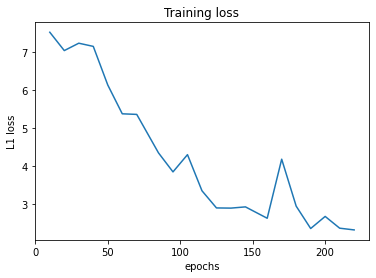

In [ ]:
#Opimizer
criterion = torch.nn.L1Loss(reduction='sum').to(cuda0)
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))

myI = 0
channels = 2
iterations = []
losses = []

start_time = time.time()

for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
      
        batch_imgs, batch_imgs_t, labels = data

        optimizer.zero_grad()

        # forward + backward + optimize
        batch_imgs = batch_imgs.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
        batch_imgs_t = batch_imgs_t.to(device=cuda0, dtype=torch.float)
        # inputs = inputs.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
        labels = labels.to(device=cuda0, dtype=torch.float)

        outputs = net(batch_imgs, batch_imgs_t)

        # outputs = outputs.reshape((5))
        loss_dx = criterion(outputs[:, 0], labels[:, 0])
        loss_dy = criterion(outputs[:, 1], labels[:, 1])
        loss_theta = criterion(outputs[:, 2], labels[:, 2])
        loss_sx = criterion(outputs[:, 3], labels[:, 3])
        loss_sy = criterion(outputs[:, 4], labels[:, 4])

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print(f'epoch = {epoch}, minibatch = {i}, loss = {loss.item()}')
        myI += 1
        
        if myI % 3000 == 2999:
          print('saving model')
          PATH = os.path.join(PATH_TO_MODELS, f'm_{epoch}_{running_loss/10}.pth')
          torch.save(net.state_dict(), PATH)

        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            print(f'dx loss = {loss_dx.item()}')
            print(f'dy loss = {loss_dy.item()}')
            print(f'theta loss = {loss_theta.item()}')
            print(f'sx loss = {loss_sx.item()}')
            print(f'sy loss = {loss_sy.item()}')
            print('-----------------------------')
            iterations.append(myI)
            losses.append(running_loss/10)
            running_loss = 0.0

stop_time = time.time()
print('Finished Training')
print(f'Training took: {stop_time-start_time} s')
# print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(iterations, losses)
plt.xlabel('epochs')
plt.ylabel('L1 loss')
plt.title("Training loss")
plt.show()

# Experiments with image size

## 128 X 128

In [ ]:
# Experiments with image size
transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Grayscale(1),
                    transforms.Resize([128, 128]), #Resize to 128x128
                    transforms.ColorJitter(brightness=(0.3,1), contrast=(0.3,1)),
                    transforms.ToTensor(),
                    transforms.Normalize(0.5, 0.5)])

affine_dataset = AffineDataset(PATH_TO_ORIGINAL_IMGS, PATH_TO_TRANSLATED_IMGS, PATH_TO_LABELS, transform=transform, norm_out=True)

print(f'Dataset size: {len(affine_dataset)}')

trainloader = DataLoader(affine_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

Dataset size: 300


## AffineNet128

In [ ]:
class AffineNet128(nn.Module):
  def __init__(self,num_classes=5,activation='ReLU', batchNorm=False):
    super(AffineNet128,self).__init__()

    if activation == 'ReLU':
      print('Using ReLU activation')
      self.activation = nn.ReLU(inplace=True)
    elif activation == 'PReLU':
      print('Using PReLU activation')
      self.activation = nn.PReLU()

    self.batchNorm = batchNorm

    # self.activation = nn.PRelU()
    if self.batchNorm:
      print('Using BatchNorm2D')
      self.feature_extraction = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=96,kernel_size=11,stride=4,padding=2,bias=False),
        nn.BatchNorm2d(96),
        self.activation,
        nn.MaxPool2d(kernel_size=3,stride=2,padding=0),

        nn.Conv2d(in_channels=96,out_channels=192,kernel_size=5,stride=1,padding=2,bias=False),
        nn.BatchNorm2d(192),
        self.activation,
        nn.MaxPool2d(kernel_size=3,stride=2,padding=0),

        nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(384),
        self.activation,

        nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(256),
        self.activation,
    
        nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(256),
        self.activation,
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
      )
    else:
      self.feature_extraction = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=96,kernel_size=11,stride=4,padding=2,bias=False),
        self.activation,
        nn.MaxPool2d(kernel_size=3,stride=2,padding=0),

        nn.Conv2d(in_channels=96,out_channels=192,kernel_size=5,stride=1,padding=2,bias=False),
        self.activation,
        nn.MaxPool2d(kernel_size=3,stride=2,padding=0),

        nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,stride=1,padding=1,bias=False),
        self.activation,

        nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
        self.activation,
    
        nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
        self.activation,
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
      )

    self.classifier = nn.Sequential(
      # nn.Dropout(p=0.5),
      # nn.Linear(in_features=4608,out_features=9216),

      # self.activation,
      # nn.Dropout(p=0.5),
      # nn.Linear(in_features=9216,out_features=4096),
      # self.activation,

      nn.Dropout(p=0.5),
      nn.Linear(in_features=4608, out_features=2048),
      self.activation,

      nn.Dropout(p=0.5),
      nn.Linear(in_features=2048, out_features=1024),
      self.activation,
      nn.Linear(in_features=1024, out_features=num_classes),
    )
  def forward(self, x1, x2):
    x1 = self.feature_extraction(x1)
    x2 = self.feature_extraction(x2)
    x = torch.cat((x1, x2), 1)
    # x = x.view(x.size(0),256*6*6)
    x = x.view(x.size(0),-1)
    x = self.classifier(x)
    return x


## Train

Using PReLU activation
---------- Network initialized -------------
[Network] Total number of parameters : 14.153 M
-----------------------------------------------
GPU : Tesla P100-PCIE-16GB
[1,    10] loss: 6.635
dx loss = 1.3177403211593628
dy loss = 0.7330067157745361
theta loss = 0.5935567021369934
sx loss = 0.7041733264923096
sy loss = 0.6789344549179077
-----------------------------
[1,    20] loss: 3.051
dx loss = 0.546937108039856
dy loss = 0.7718102931976318
theta loss = 0.38238728046417236
sx loss = 0.5680621266365051
sy loss = 0.5068135857582092
-----------------------------
[1,    30] loss: 2.705
dx loss = 0.524549126625061
dy loss = 0.30708378553390503
theta loss = 0.4154329001903534
sx loss = 0.41251569986343384
sy loss = 0.44734400510787964
-----------------------------
[1,    40] loss: 3.527
dx loss = 0.32750117778778076
dy loss = 0.5335623621940613
theta loss = 0.20472437143325806
sx loss = 0.20484423637390137
sy loss = 0.4600142240524292
-----------------------------


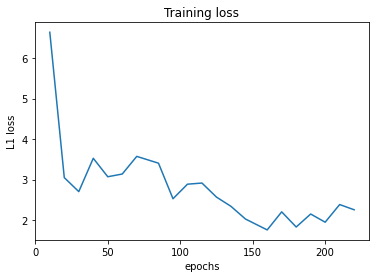

In [ ]:
net = AffineNet128(activation='PReLU')
# net = AffineNet()

print('---------- Network initialized -------------')
num_params = 0
for param in net.parameters():
  num_params += param.numel()
print('[Network] Total number of parameters : %.3f M' % (num_params / 1e6))
print('-----------------------------------------------')

if torch.cuda.is_available():
  print(f'GPU : {torch.cuda.get_device_name(0)}')
  cuda0 = torch.device('cuda:0')
  net.cuda()


#Opimizer
criterion = torch.nn.L1Loss(reduction='sum').to(cuda0)
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))

myI = 0
channels = 2
iterations = []
losses = []

start_time = time.time()

for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
      
        batch_imgs, batch_imgs_t, labels = data

        optimizer.zero_grad()

        # forward + backward + optimize
        batch_imgs = batch_imgs.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
        batch_imgs_t = batch_imgs_t.to(device=cuda0, dtype=torch.float)
        # inputs = inputs.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
        labels = labels.to(device=cuda0, dtype=torch.float)

        outputs = net(batch_imgs, batch_imgs_t)

        # outputs = outputs.reshape((5))
        loss_dx = criterion(outputs[:, 0], labels[:, 0])
        loss_dy = criterion(outputs[:, 1], labels[:, 1])
        loss_theta = criterion(outputs[:, 2], labels[:, 2])
        loss_sx = criterion(outputs[:, 3], labels[:, 3])
        loss_sy = criterion(outputs[:, 4], labels[:, 4])

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print(f'epoch = {epoch}, minibatch = {i}, loss = {loss.item()}')
        myI += 1
        
        if myI % 3000 == 2999:
          print('saving model')
          PATH = os.path.join(PATH_TO_MODELS, f'm_{epoch}_{running_loss/10}.pth')
          torch.save(net.state_dict(), PATH)

        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            print(f'dx loss = {loss_dx.item()}')
            print(f'dy loss = {loss_dy.item()}')
            print(f'theta loss = {loss_theta.item()}')
            print(f'sx loss = {loss_sx.item()}')
            print(f'sy loss = {loss_sy.item()}')
            print('-----------------------------')
            iterations.append(myI)
            losses.append(running_loss/10)
            running_loss = 0.0

stop_time = time.time()
print('Finished Training')
print(f'Training took: {stop_time-start_time} s')
# print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(iterations, losses)
plt.xlabel('epochs')
plt.ylabel('L1 loss')
plt.title("Training loss")
plt.show()

## 32 X 32

In [ ]:
# Experiments with image size
transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Grayscale(1),
                    transforms.Resize([32, 32]), #Resize to 32x32
                    transforms.ColorJitter(brightness=(0.3,1), contrast=(0.3,1)),
                    transforms.ToTensor(),
                    transforms.Normalize(0.5, 0.5)])

affine_dataset = AffineDataset(PATH_TO_ORIGINAL_IMGS, PATH_TO_TRANSLATED_IMGS, PATH_TO_LABELS, transform=transform, norm_out=True)

print(f'Dataset size: {len(affine_dataset)}')

trainloader = DataLoader(affine_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

Dataset size: 300


## AffineNet32

In [ ]:
class AffineNet32(nn.Module):
  def __init__(self,num_classes=5,activation='ReLU', batchNorm=False):
    super(AffineNet32,self).__init__()

    if activation == 'ReLU':
      print('Using ReLU activation')
      self.activation = nn.ReLU(inplace=True)
    elif activation == 'PReLU':
      print('Using PReLU activation')
      self.activation = nn.PReLU()

    self.batchNorm = batchNorm

    # self.activation = nn.PRelU()
    if self.batchNorm:
      print('Using BatchNorm2D')
      self.feature_extraction = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=96,kernel_size=11,stride=4,padding=2,bias=False),
        nn.BatchNorm2d(96),
        self.activation,
        nn.MaxPool2d(kernel_size=3,stride=2,padding=0),

        nn.Conv2d(in_channels=96,out_channels=192,kernel_size=5,stride=1,padding=2,bias=False),
        nn.BatchNorm2d(192),
        self.activation,
        nn.MaxPool2d(kernel_size=3,stride=2,padding=0),

        nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(384),
        self.activation,

        nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(256),
        self.activation,
    
        nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(256),
        self.activation,
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
      )
    else:
      self.feature_extraction = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=96,kernel_size=11,stride=4,padding=2,bias=False),
        self.activation,
        nn.MaxPool2d(kernel_size=3,stride=2,padding=0),

        nn.Conv2d(in_channels=96,out_channels=192,kernel_size=5,stride=1,padding=2,bias=False),
        self.activation,
        nn.MaxPool2d(kernel_size=3,stride=2,padding=0),

        # nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,stride=1,padding=1,bias=False),
        # self.activation,

        # nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
        # self.activation,
    
        # nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
        # self.activation,
        # nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
      )

    self.classifier = nn.Sequential(
      # nn.Dropout(p=0.5),
      # nn.Linear(in_features=4608,out_features=9216),

      # self.activation,
      # nn.Dropout(p=0.5),
      # nn.Linear(in_features=9216,out_features=4096),
      # self.activation,

      nn.Dropout(p=0.5),
      nn.Linear(in_features=384, out_features=256),
      self.activation,

      nn.Dropout(p=0.5),
      nn.Linear(in_features=256, out_features=num_classes),
      # self.activation,
      # nn.Linear(in_features=1024, out_features=num_classes),
    )
  def forward(self, x1, x2):
    x1 = self.feature_extraction(x1)
    x2 = self.feature_extraction(x2)
    x = torch.cat((x1, x2), 1)
    # x = x.view(x.size(0),256*6*6)
    x = x.view(x.size(0),-1)
    x = self.classifier(x)
    return x


## Train

Using PReLU activation
---------- Network initialized -------------
[Network] Total number of parameters : 0.572 M
-----------------------------------------------
GPU : Tesla P100-PCIE-16GB
[1,    10] loss: 8.674
dx loss = 0.9452457427978516
dy loss = 0.9136140942573547
theta loss = 1.5838385820388794
sx loss = 1.5937702655792236
sy loss = 2.091655731201172
-----------------------------
[1,    20] loss: 5.962
dx loss = 0.5910196304321289
dy loss = 1.0306717157363892
theta loss = 1.173002004623413
sx loss = 1.210815191268921
sy loss = 1.2913930416107178
-----------------------------
[1,    30] loss: 3.671
dx loss = 0.6924576759338379
dy loss = 0.7654312252998352
theta loss = 0.5890620350837708
sx loss = 0.5581524968147278
sy loss = 0.7940968871116638
-----------------------------
[1,    40] loss: 3.814
dx loss = 0.7408137917518616
dy loss = 0.7033814191818237
theta loss = 0.6028324365615845
sx loss = 0.5574008226394653
sy loss = 1.0124790668487549
-----------------------------
[1,    50

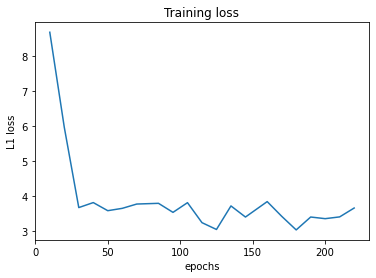

In [ ]:
net = AffineNet32(activation='PReLU')
# net = AffineNet()

print('---------- Network initialized -------------')
num_params = 0
for param in net.parameters():
  num_params += param.numel()
print('[Network] Total number of parameters : %.3f M' % (num_params / 1e6))
print('-----------------------------------------------')

if torch.cuda.is_available():
  print(f'GPU : {torch.cuda.get_device_name(0)}')
  cuda0 = torch.device('cuda:0')
  net.cuda()


#Opimizer
criterion = torch.nn.L1Loss(reduction='sum').to(cuda0)
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))

myI = 0
channels = 2
iterations = []
losses = []

start_time = time.time()

for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
      
        batch_imgs, batch_imgs_t, labels = data

        optimizer.zero_grad()

        # forward + backward + optimize
        batch_imgs = batch_imgs.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
        batch_imgs_t = batch_imgs_t.to(device=cuda0, dtype=torch.float)
        # inputs = inputs.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
        labels = labels.to(device=cuda0, dtype=torch.float)

        outputs = net(batch_imgs, batch_imgs_t)

        # outputs = outputs.reshape((5))
        loss_dx = criterion(outputs[:, 0], labels[:, 0])
        loss_dy = criterion(outputs[:, 1], labels[:, 1])
        loss_theta = criterion(outputs[:, 2], labels[:, 2])
        loss_sx = criterion(outputs[:, 3], labels[:, 3])
        loss_sy = criterion(outputs[:, 4], labels[:, 4])

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print(f'epoch = {epoch}, minibatch = {i}, loss = {loss.item()}')
        myI += 1
        
        if myI % 3000 == 2999:
          print('saving model')
          PATH = os.path.join(PATH_TO_MODELS, f'm_{epoch}_{running_loss/10}.pth')
          torch.save(net.state_dict(), PATH)

        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            print(f'dx loss = {loss_dx.item()}')
            print(f'dy loss = {loss_dy.item()}')
            print(f'theta loss = {loss_theta.item()}')
            print(f'sx loss = {loss_sx.item()}')
            print(f'sy loss = {loss_sy.item()}')
            print('-----------------------------')
            iterations.append(myI)
            losses.append(running_loss/10)
            running_loss = 0.0

stop_time = time.time()
print('Finished Training')
print(f'Training took: {stop_time-start_time} s')
# print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(iterations, losses)
plt.xlabel('epochs')
plt.ylabel('L1 loss')
plt.title("Training loss")
plt.show()